In [129]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))

In [130]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']

In [131]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [132]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)

In [133]:
from xml.dom.minidom import parse, Node

def set_id_attribute(parent, attribute_name="id"):
    if parent.nodeType == Node.ELEMENT_NODE:
        if parent.hasAttribute(attribute_name):
            parent.setIdAttribute(attribute_name)
    for child in parent.childNodes:
        set_id_attribute(child, attribute_name)

def remove_whitespace(node):
    if node.nodeType == Node.TEXT_NODE:
        if node.nodeValue.strip() == "":
            node.nodeValue = ""
    for child in node.childNodes:
        remove_whitespace(child)

document = parse("en_dimlex.xml")
set_id_attribute(document)
remove_whitespace(document)
document.normalize()

conns = []
for id in range(1,143):
    e = document.getElementById(str(id))
    word = e.getAttribute('word')
    syns = []
    for syn in e.getElementsByTagName("syn"):
        cat = syn.firstChild.firstChild.nodeValue
        cur_syn = {}
        cur_syn['cat'] = cat
        sems = []
        for sem in syn.getElementsByTagName("sem"):
            sense = sem.firstChild.getAttribute('sense')
            pdtb_freq = sem.firstChild.getAttribute('pdtb_freq')
            s = {'sense': sense, 'pdtb_freq': pdtb_freq}
            sems.append(s)
        cur_syn['sems'] = sems
        syns.append(cur_syn)
    modifiers = []
    for pdtb_m in e.getElementsByTagName("pdtb_modifiers"):
        for mod in pdtb_m.getElementsByTagName("modifier"):
            modifier = mod.firstChild.nodeValue
            modifiers.append(modifier)
    conns.append({'word': word, 'syns': syns, 'modifiers': modifiers})

connectives = pd.DataFrame(conns)
connectives.loc[len(connectives)] = ['during', [], []]

In [134]:
def findDepWithWord(row, kwargs):
    word = kwargs[0]
    for t in row['rel_deps']:
        if t[1] == word and t[3] == row['gerund']: #or t[3] == word and t[1] == row['gerund']:
            return t[0]
    return ''

In [135]:
for word in connectives['word']:
    p_data[word] = p_data.apply(findDepWithWord, kwargs=[word], axis=1)

In [136]:
p_data[p_data['although'] != '']['although']

1823     mark
6619     mark
12539    mark
29443    mark
29651    mark
30590    mark
37627    mark
38690    mark
42484    mark
42615    mark
Name: although, dtype: object

In [137]:
gerund_types = list(p_data['type'].unique())
disallowed_deps = ['', 'amod', 'advmod']

cols = gerund_types.copy()
cols.insert(0, 'word')
cols.append('total_count')
conn_stats = pd.DataFrame(columns=cols)
for word in connectives['word']:
    rows = p_data[~p_data[word].isin(disallowed_deps)]
    val_counts = rows['type'].value_counts()
    counts = [word]
    for t in cols[1:7]:
        if t in val_counts.index:
            counts.append(val_counts[t])
        else:
            counts.append(0)
    counts.append(np.sum(counts[1:]))
    conn_stats.loc[len(conn_stats.index)] = counts

In [138]:
conn_types = ['Comparison', 'Expansion', 'Contingency', 'Temporal']
for index, row in connectives.iterrows():
    conn_type_freq = {}
    total_count = 0
    for t in conn_types:
        conn_type_freq[t] = 0
    for item in row['syns']:
        for sem in item['sems']:
            if sem['pdtb_freq'].isdigit():
                conn_type_freq[sem['sense'].split('.')[0]] += int(sem['pdtb_freq'])
                total_count += int(sem['pdtb_freq'])
    for t in conn_types:
        if total_count == 0:
            total_count = 1
        connectives.loc[index, t] = conn_type_freq[t] / total_count

In [139]:
for index, row in conn_stats.iterrows():
    for t in conn_types:
        conn_stats.loc[index, t] = connectives[connectives['word'] == row['word']][t].iloc[0]

In [140]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(conn_stats[['word', 'total_count']])

                                  word  total_count
0                                 once            3
1                             although           10
2                               though            8
3                                  but          147
4                              because           32
5                         nevertheless            0
6                               before          158
7                          for example            0
8                                until            9
9                                   if           26
10                          previously            0
11                                when          202
12                                 and         3890
13                                  so            1
14                                then            1
15                               while          406
16                          as long as            0
17                             however            0
18          

In [141]:
for t in gerund_types:
    new_col = t + '_normalized'
    conn_stats[new_col] = conn_stats[t].div(conn_stats['total_count'], axis=0)

In [142]:
common_words = conn_stats[conn_stats['total_count'] >= 50]

In [143]:
common_words_corr = common_words[~common_words['word'].isin(['with', 'without', 'upon'])].corr()
conn_stats_corr = conn_stats.corr()

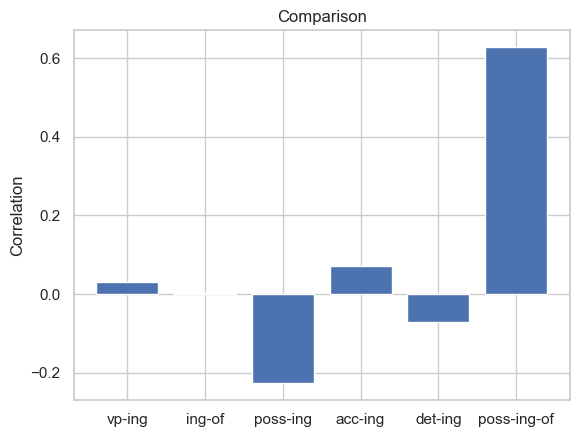

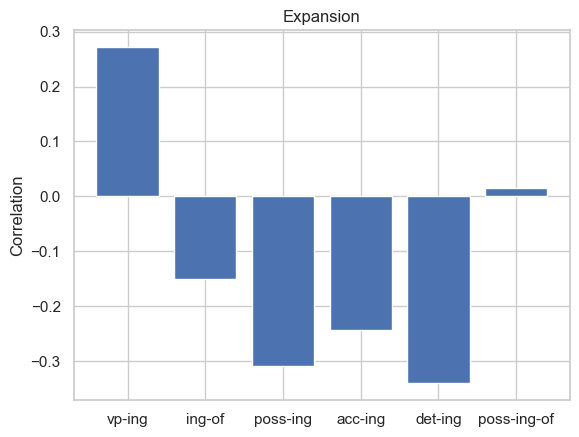

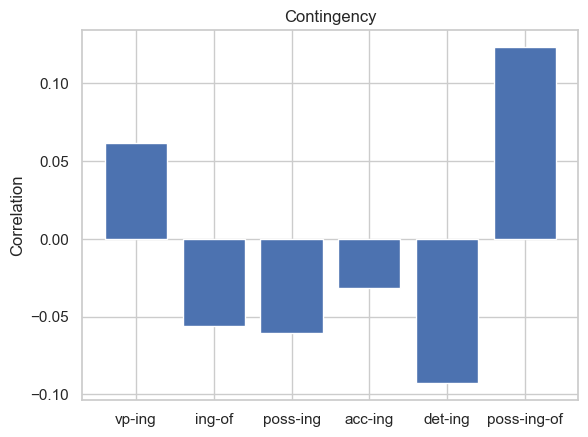

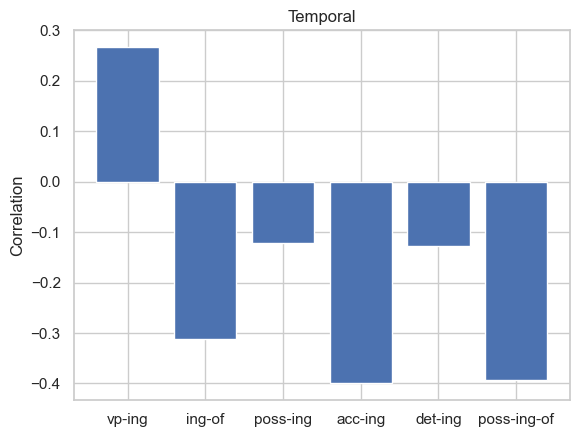

In [144]:
for ct in conn_types:
    names = []
    h = []
    for gt in gerund_types:
        names.append(gt)
        h.append(common_words_corr.loc[ct, gt+'_normalized'])
    plt.figure()
    plt.bar(names, h)
    plt.title(ct)
    plt.ylabel('Correlation')

In [145]:
def exampleSentence(conn, gerund_type, dep=None, gerund=None, i=0):
    if dep==None and gerund==None:
        examples = p_data[~(p_data[conn].isin(disallowed_deps)) & (p_data['type'] == gerund_type)]
    elif dep==None:
        examples = p_data[~(p_data[conn].isin(disallowed_deps)) & (p_data['type'] == gerund_type) & (p_data['gerund'].str.lower() == gerund.lower())]
    elif gerund==None:
        examples = p_data[(p_data[conn] == dep) & (p_data['type'] == gerund_type)]
    else:
        examples = p_data[(p_data[conn] == dep) & (p_data['type'] == gerund_type) & (p_data['gerund'].str.lower() == gerund.lower())]
    if i < len(examples):
        return examples.iloc[i]['sentence'], len(examples)
    return '', len(examples)

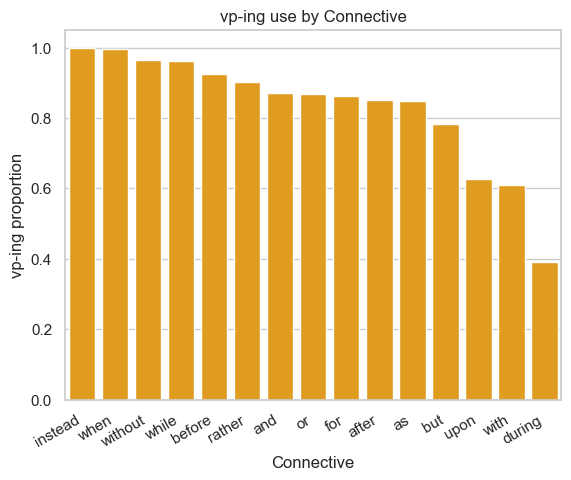

In [146]:
common_words = common_words.sort_values('vp-ing_normalized', ascending=False)
ax = sns.barplot(common_words, x='word', y='vp-ing_normalized', color='orange')
ax.set(xlabel='Connective', ylabel='vp-ing proportion', title='vp-ing use by Connective')
plt.xticks(rotation=30, ha='right')
plt.show()

In [147]:
p_words = ['before', 'after', 'with', 'without', 'while', 'during']

In [148]:
paired_words = common_words[common_words['word'].isin(['before', 'after', 'with', 'without', 'while', 'during'])]

In [149]:
p2_words = pd.DataFrame(columns=['word', 'gerund_type', 'proportion'])
for w in p_words:
    for g in gerund_types:
        p2_words.loc[len(p2_words)] = [w, g, common_words[common_words['word'] == w][g + "_normalized"].iloc[0]]

Text(0.5, 0.98, 'Paired Gerund Type Comparison')

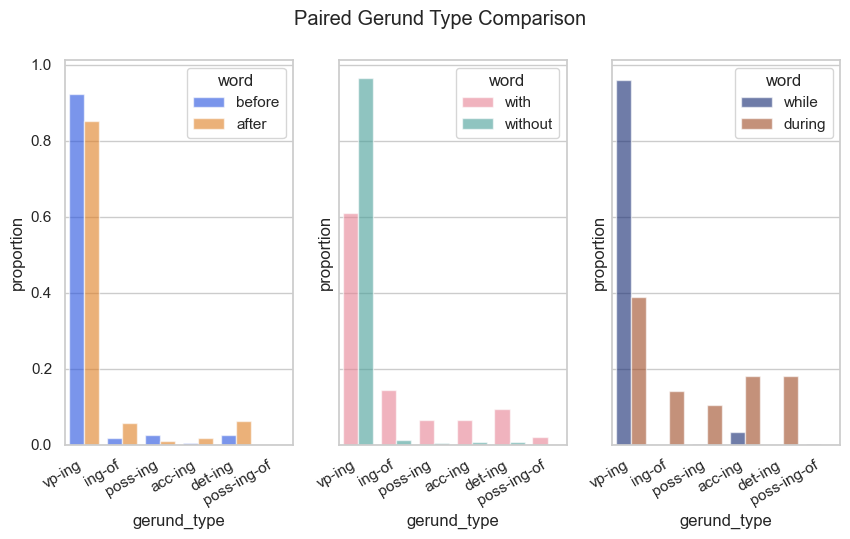

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
sns.barplot(
    data=p2_words[p2_words['word'].isin(['before', 'after'])], 
    x="gerund_type", y="proportion", hue="word", palette="bright", alpha=.6, ax=axes[0]
)
plt.xticks(rotation=30, ha='right')
sns.barplot(
    data=p2_words[p2_words['word'].isin(['with', 'without'])], 
    x="gerund_type", y="proportion", hue="word", palette="husl", alpha=.6, ax=axes[1]
)
plt.xticks(rotation=30, ha='right')
sns.barplot(
    data=p2_words[p2_words['word'].isin(['while', 'during'])], 
    x="gerund_type", y="proportion", hue="word", palette="dark", alpha=.6, ax=axes[2]
)
for a in axes:
    a.set_xticks(a.get_xticks(), a.get_xticklabels(), rotation=30, ha='right')

fig.suptitle('Paired Gerund Type Comparison')

In [151]:
conn_type_stats = pd.DataFrame(columns=['conn_type', 'gerund_type', 'proportion'])
for c in conn_types:
    for g in gerund_types:
        conn_type_stats.loc[len(conn_type_stats)] = [c, g, np.dot((common_words[c] / sum(common_words[c])).to_numpy(),common_words[g + '_normalized'])]

[Text(0.5, 0, 'Gerund Type'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Gerund Type by Connective Type')]

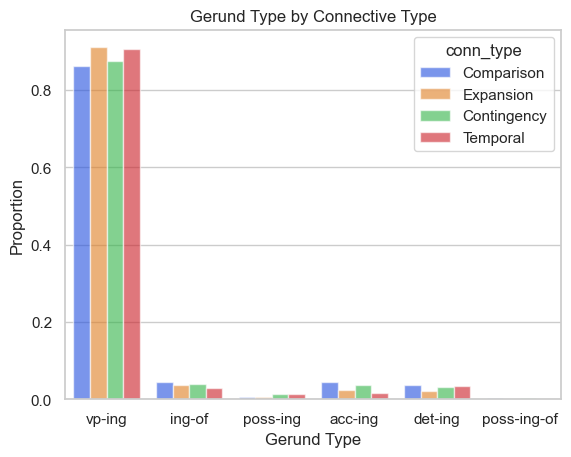

In [152]:
ax = sns.barplot(
    data=conn_type_stats, 
    x="gerund_type", y="proportion", hue="conn_type", palette="bright", alpha=.6
)
ax.set(xlabel='Gerund Type', ylabel='Proportion', title='Gerund Type by Connective Type')

Word: instead, type: vp-ing
A popular black rap singer , KRS-One , complained in an op-ed article in the New York Times that the schools should be teaching blacks about their cultural heritage , instead of trying to make everyone Americans .
Num results: 50

Word: instead, type: ing-of

Num results: 0

Word: instead, type: poss-ing

Num results: 0

Word: instead, type: acc-ing

Num results: 0

Word: instead, type: det-ing

Num results: 0

Word: instead, type: poss-ing-of

Num results: 0

Word: when, type: vp-ing
The idol of the young hero of " This Side of Paradise , " Dick Humbird , who apparently can do anything and make it look right , is killed when driving drunk , and Humbird later appears as the devil .
Num results: 201

Word: when, type: ing-of

Num results: 0

Word: when, type: poss-ing

Num results: 1

Word: when, type: acc-ing

Num results: 0

Word: when, type: det-ing

Num results: 0

Word: when, type: poss-ing-of

Num results: 0

Word: without, type: vp-ing
Given the moral 

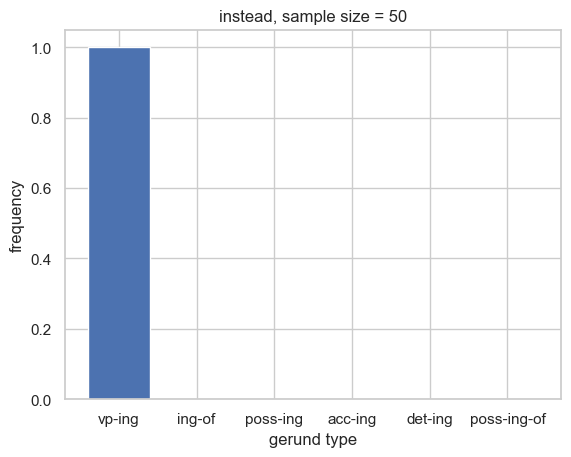

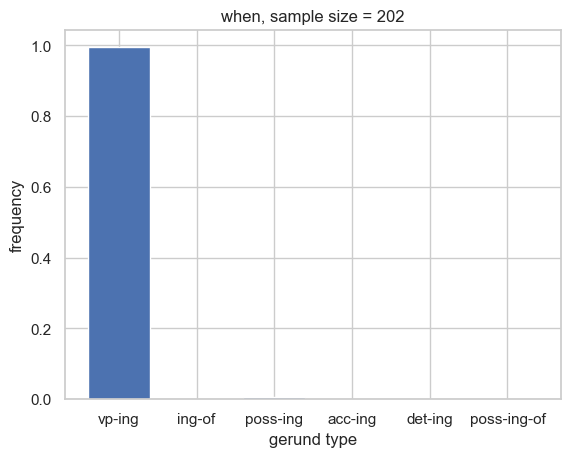

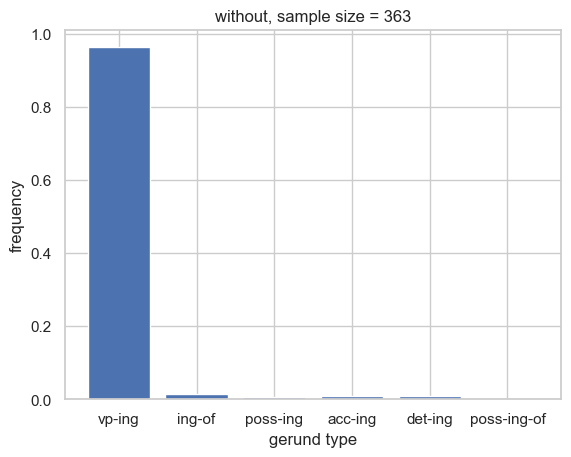

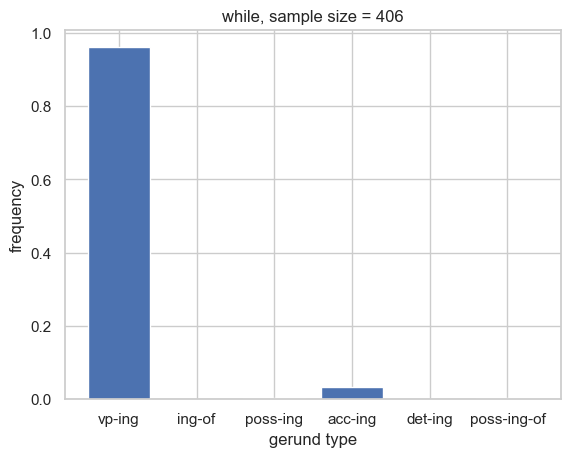

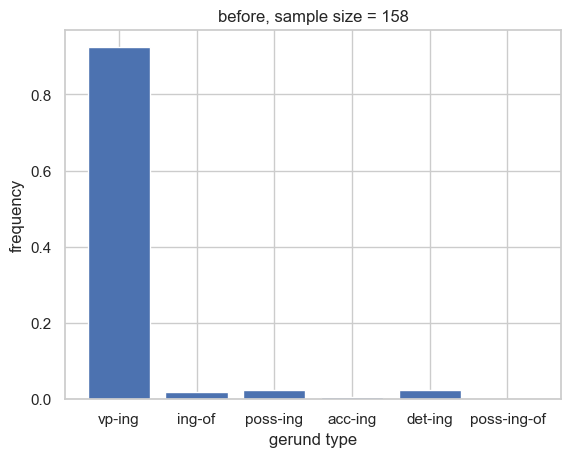

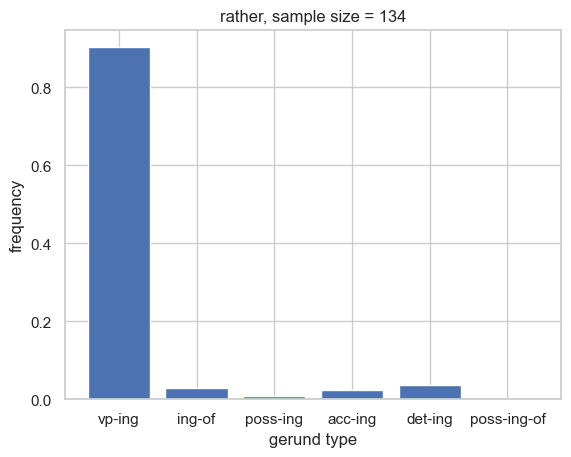

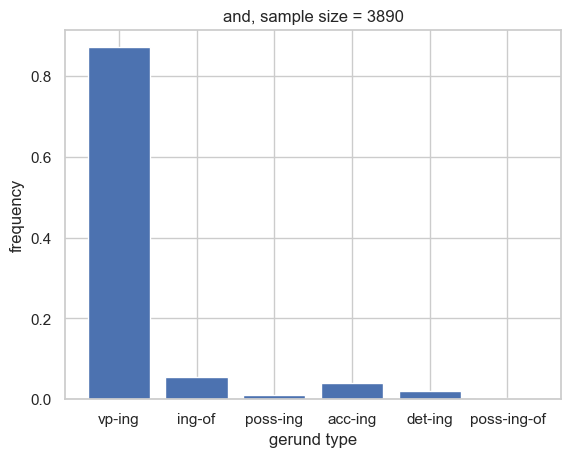

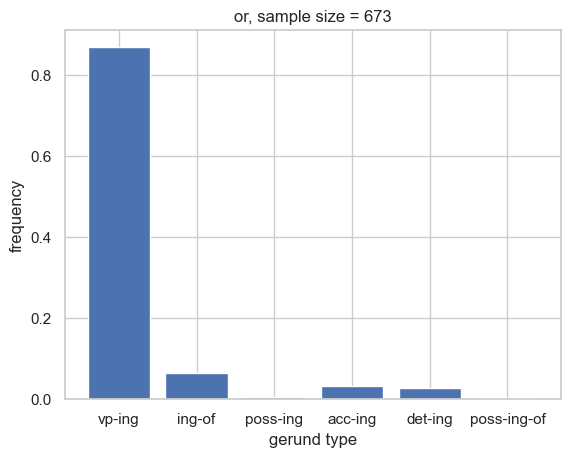

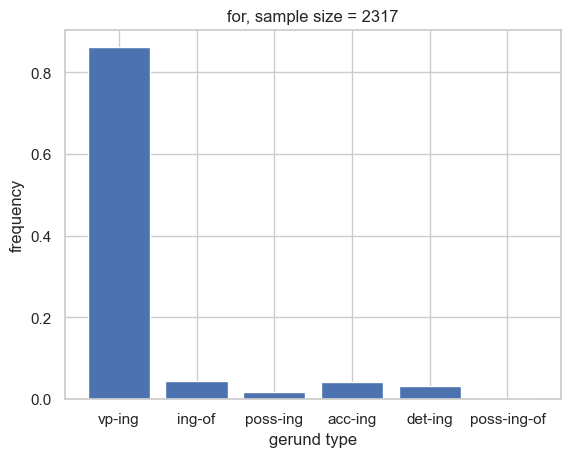

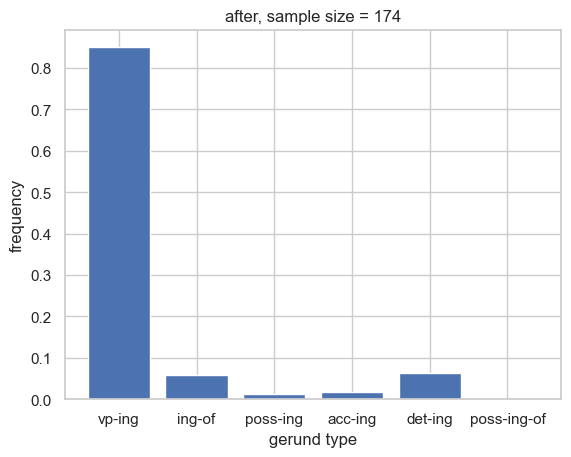

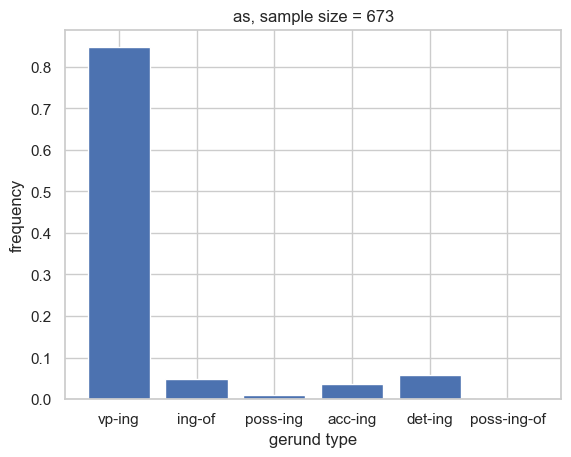

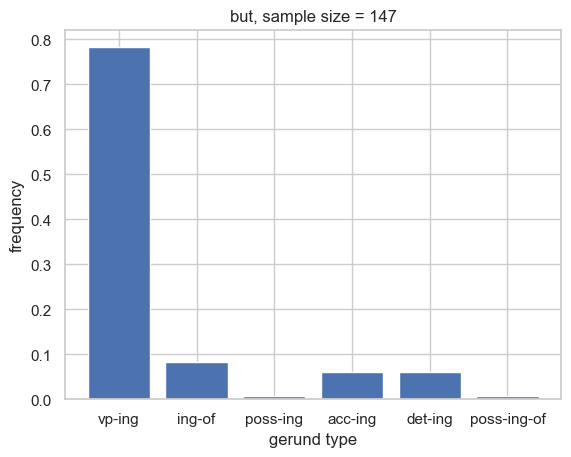

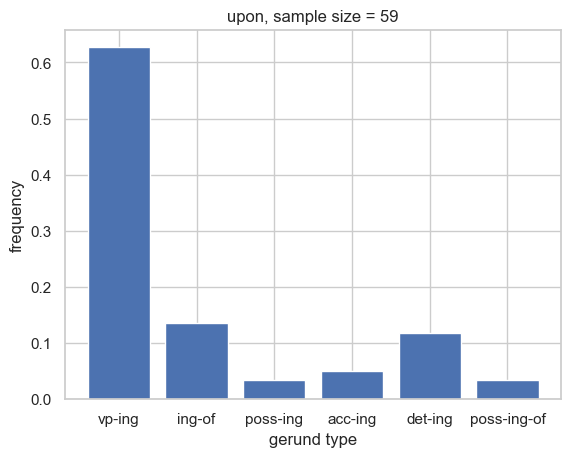

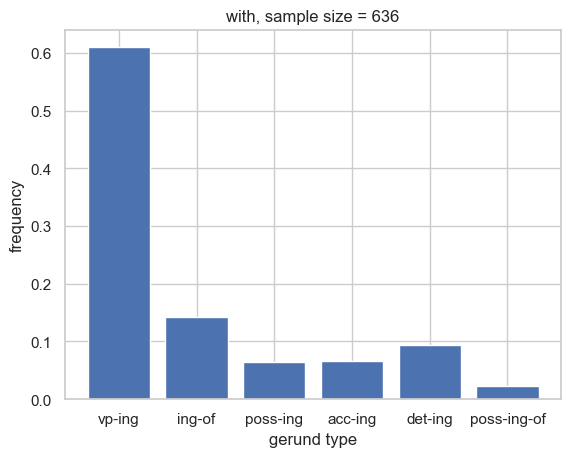

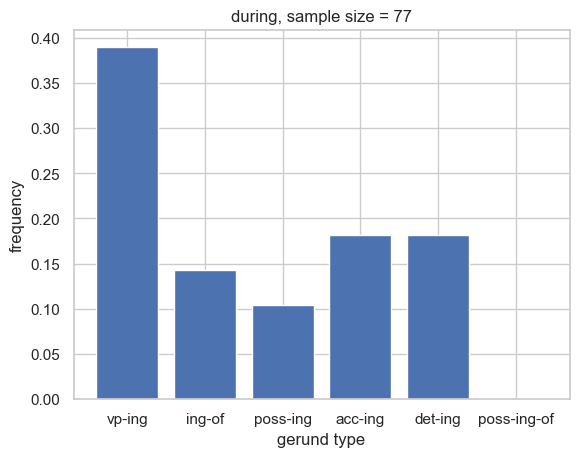

In [153]:
i = 0
for index, row in common_words.iterrows():
    total_count = row['total_count']
    if total_count == 0:
        continue
    word = row['word']
    plt.figure()
    plt.bar(gerund_types, row[[(t + "_normalized") for t in gerund_types]])
    plt.title(word + ", sample size = " + str(total_count))
    plt.xlabel('gerund type')
    plt.ylabel('frequency')
    i += 1
    for t in gerund_types:
        print('Word: ' + word + ", type: " + t)
        sent, size = exampleSentence(word, t, i=1)
        print(sent)
        print("Num results: " + str(size) + '\n')

In [154]:
connectives[connectives['word'] == 'during']

,word,syns,modifiers,Comparison,Expansion,Contingency,Temporal
142,during,[],[],0.0,0.0,0.0,0.0


In [155]:
dep_list = set()
for col in p_data[connectives['word']].columns:
    for val in p_data[connectives['word']][col].unique():
        dep_list.add(val)

In [156]:
dep_list = [
 'acl',
 'advcl',
 'advmod',
 'amod',
 'case',
 'cc',
 'ccomp',
 'conj',
 'fixed',
 'mark',
 'nmod',
 'nsubj',
 'obj',
 'obl']

In [157]:
dep_counts = {}
for d in dep_list:
    dep_counts[d] = {}
    for t in gerund_types:
        dep_counts[d][t] = 0
for index, row in p_data.iterrows():
    for conn in connectives['word']:
        if row[conn] != '':
            dep_counts[row[conn]][row['type']] += 1

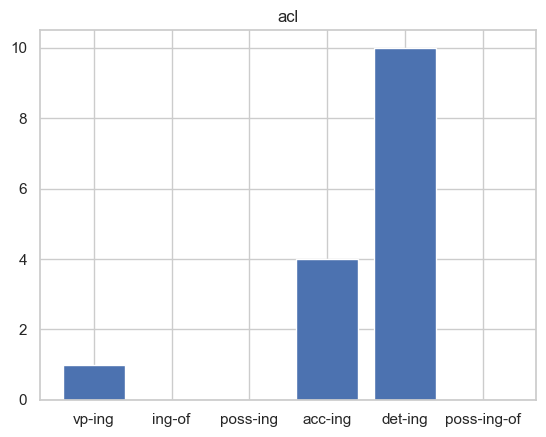

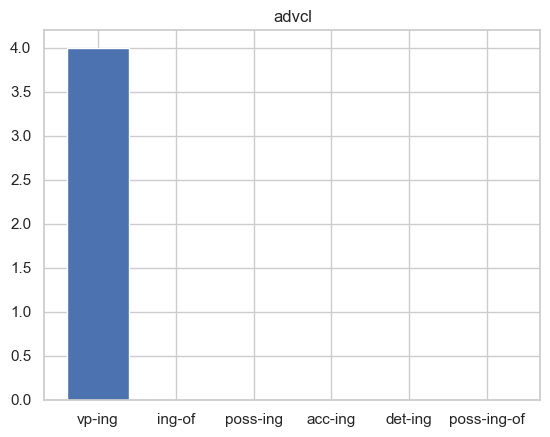

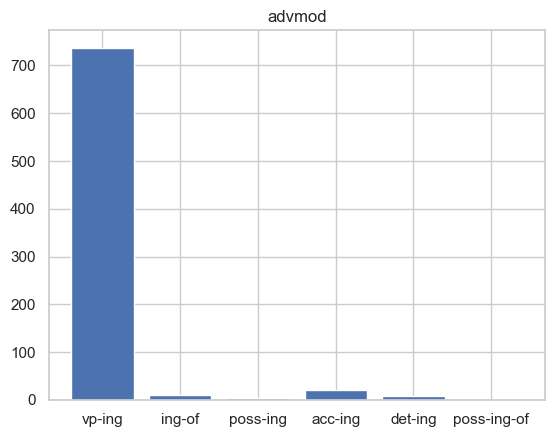

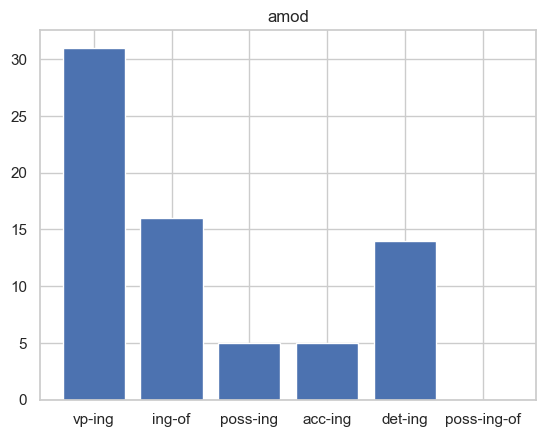

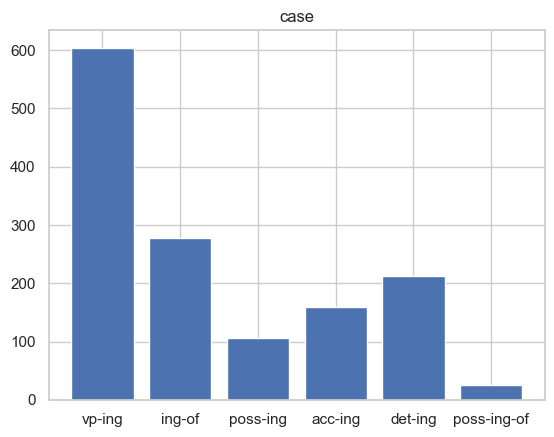

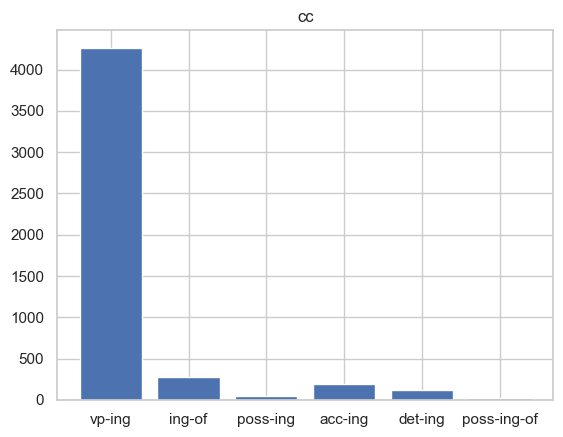

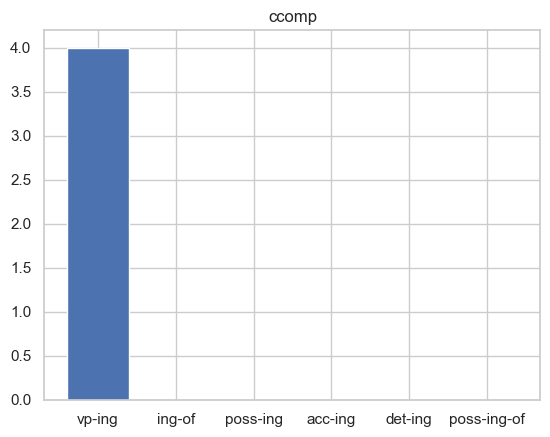

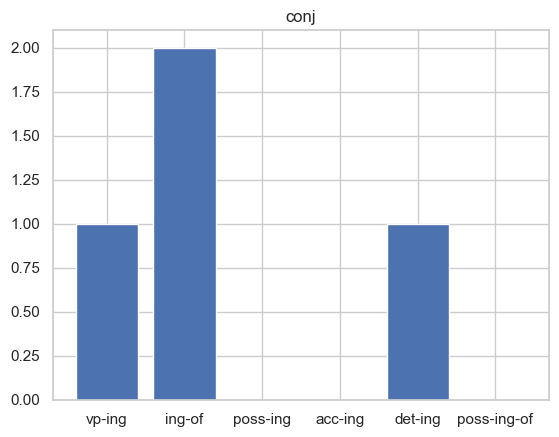

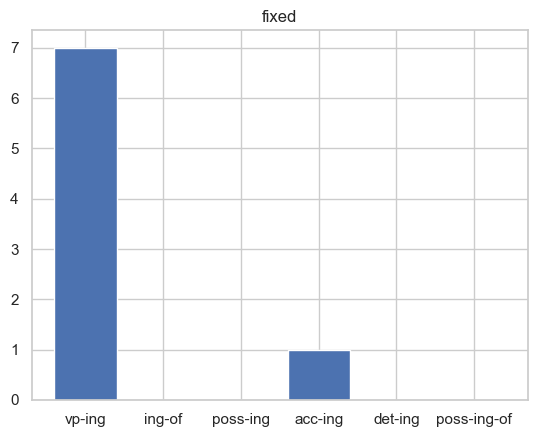

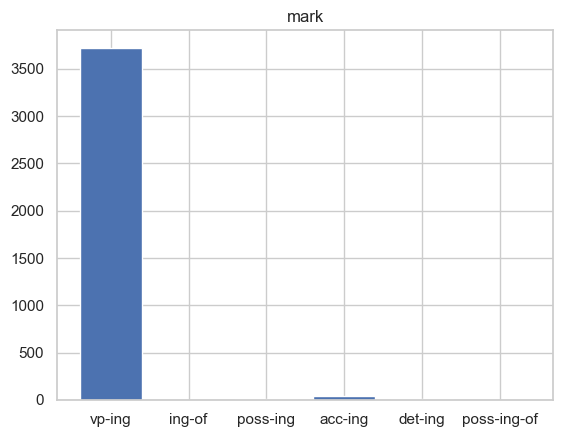

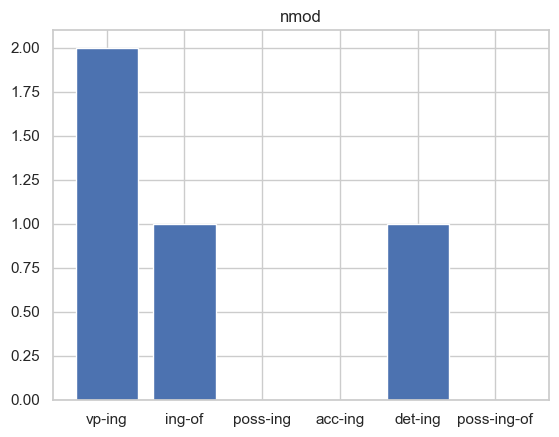

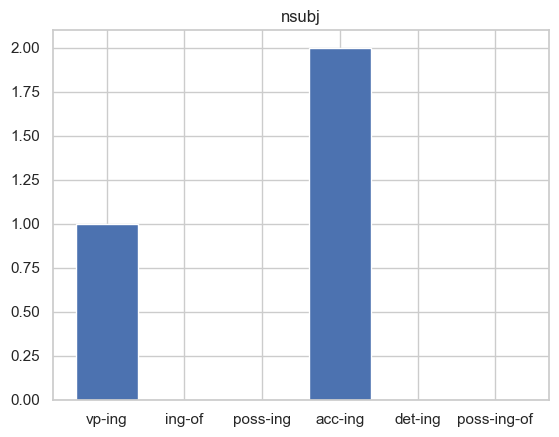

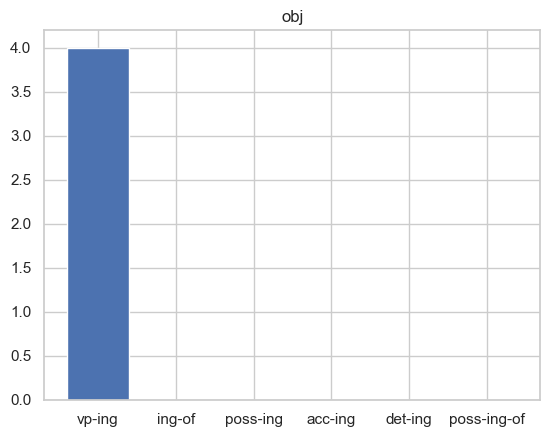

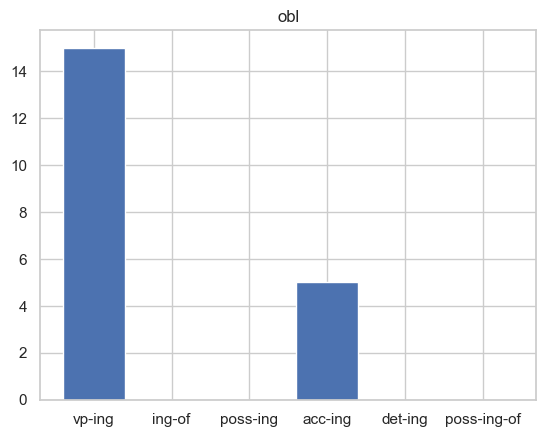

In [158]:
for d in dep_list:
    h = []
    for t in gerund_types:
        h.append(dep_counts[d][t])
    plt.figure()
    plt.bar(gerund_types, h)
    plt.title(d)
